In [271]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image

df = pd.read_csv('images.csv')
size = 28
sample = 0

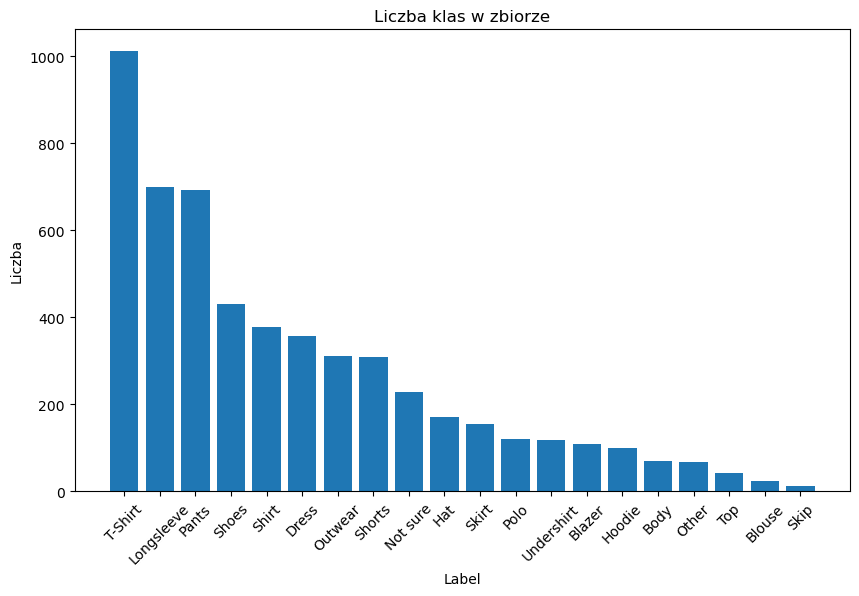

In [272]:
label_counts = df['label'].value_counts()
unique_labels = label_counts.index

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel('Label')
plt.ylabel('Liczba')
plt.title('Liczba klas w zbiorze')
plt.xticks(rotation=45)
plt.show()

In [273]:
label_mapping = {
    'Not sure': 0,
    'T-Shirt': 1,
    'Shoes': 2,
    'Shorts' : 3,
    'Shirt' : 4,
    'Pants' : 5,
    'Skirt' : 6,
    'Other' : 7,
    'Top' : 8,
    'Outwear' : 9,
    'Dress' : 10,
    'Body' : 11,
    'Longsleeve' : 12,
    'Undershirt' : 13,
    'Hat' : 14,
    'Polo' : 15,
    'Blouse' : 16,
    'Hoodie' : 17,
    'Skip' : 18,
    'Blazer' : 19
}

df['label'] = df['label'].map(label_mapping)

print(df)

                                     image  sender_id  label   kids
0     4285fab0-751a-4b74-8e9b-43af05deee22        124      0  False
1     ea7b6656-3f84-4eb3-9099-23e623fc1018        148      1  False
2     00627a3f-0477-401c-95eb-92642cbe078d         94      0  False
3     ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43      1  False
4     3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189      2  False
...                                    ...        ...    ...    ...
5398  dfd4079d-967b-4b3e-8574-fbac11b58103        204      3  False
5399  befa14be-8140-4faf-8061-1039947e329d        204     11   True
5400  5379356a-40ee-4890-b416-2336a7d84061        310      3  False
5401  65507fb8-3456-4c15-b53e-d1b03bf71a59        204      2  False
5402  32b99302-cec7-4dec-adfa-3d4029674209        204      6  False

[5403 rows x 4 columns]


In [274]:
num_samples = len(df)
images = np.empty((num_samples, size, size), dtype=np.uint8)
labels = np.empty(num_samples, dtype=np.uint8)

for i, row in df.iterrows():
    image_path = row['image']
    label = row['label']

    image_path = 'images/' + image_path + '.jpg'

    if os.path.exists(image_path):
        image = Image.open(image_path).convert('L')

        image = image.resize((size, size))

        image_array = np.array(image)

        images[i] = image_array
        labels[i] = label
        image.close
    else:
        print(f"Image not found: {image_path}")

Image not found: images/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg
Image not found: images/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
Image not found: images/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg
Image not found: images/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
Image not found: images/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg


In [275]:
print(images.shape)
print(labels.shape)

(5403, 28, 28)
(5403,)


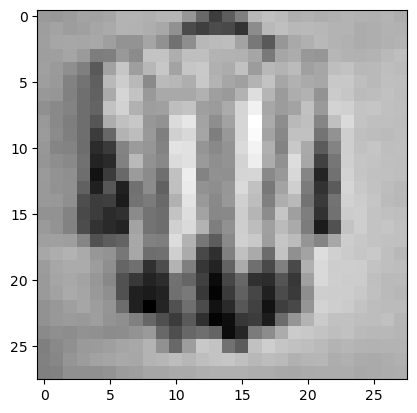

In [276]:
image = images[sample]

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [277]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.reshape((4862, size, size, 1)) / 255.0
X_test = X_test.reshape((541, size, size, 1)) / 255.0

print('Training data oryginal shape', X_train.shape)
print('Testing data oryginal shape', X_test.shape)

Training data oryginal shape (4862, 28, 28, 1)
Testing data oryginal shape (541, 28, 28, 1)


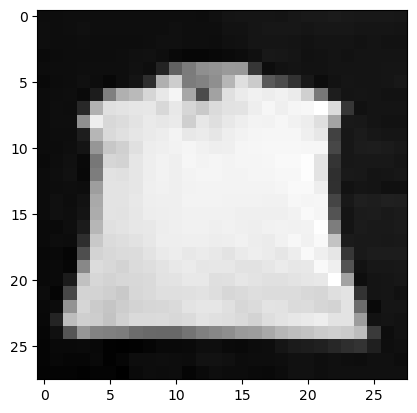

In [278]:
image = X_train[sample]

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

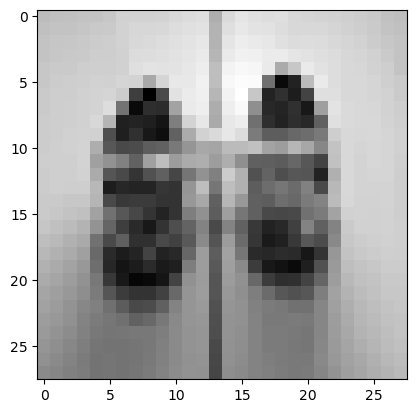

In [279]:
image = X_test[sample]

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [280]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_282 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_282 (MaxPooli  (None, 13, 13, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_103 (Flatten)       (None, 5408)              0         
                                                                 
 dense_208 (Dense)           (None, 64)                346176    
                                                                 
 dense_209 (Dense)           (None, 20)                1300      
                                                                 
Total params: 347,796
Trainable params: 347,796
Non-trainable params: 0
______________________________________________

In [281]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

X_train = X_train.reshape(-1, size, size, 1)
X_test = X_test.reshape(-1, size, size, 1)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
152/152 [==============================] - 1s 6ms/step - loss: 2.4363 - accuracy: 0.2877 - val_loss: 2.2187 - val_accuracy: 0.3771
Epoch 2/10
152/152 [==============================] - 1s 5ms/step - loss: 2.0359 - accuracy: 0.4198 - val_loss: 1.9688 - val_accuracy: 0.4584
Epoch 3/10
152/152 [==============================] - 1s 5ms/step - loss: 1.7769 - accuracy: 0.4838 - val_loss: 1.8109 - val_accuracy: 0.4880
Epoch 4/10
152/152 [==============================] - 1s 5ms/step - loss: 1.6167 - accuracy: 0.5247 - val_loss: 1.7191 - val_accuracy: 0.5231
Epoch 5/10
152/152 [==============================] - 1s 5ms/step - loss: 1.4957 - accuracy: 0.5650 - val_loss: 1.6655 - val_accuracy: 0.5213
Epoch 6/10
152/152 [==============================] - 1s 5ms/step - loss: 1.3983 - accuracy: 0.5854 - val_loss: 1.6034 - val_accuracy: 0.5360
Epoch 7/10
152/152 [==============================] - 1s 5ms/step - loss: 1.3051 - accuracy: 0.6057 - val_loss: 1.5710 - val_accuracy: 0.5453
Epoch 

In [282]:
model.save('model.h5')

score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

17/17 [==============================] - 0s 2ms/step - loss: 1.5476 - accuracy: 0.5619
Test loss: 1.5476288795471191
Test accuracy: 0.5619223713874817


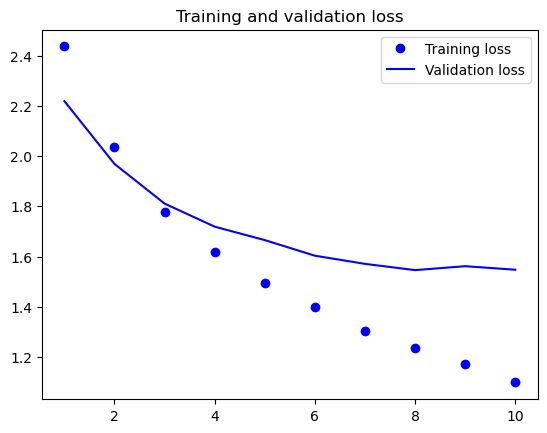

In [283]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [192]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(num_classes, activation='softmax'))

model2.summary()

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_277 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_340 (Ba  (None, 26, 26, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_277 (MaxPooli  (None, 13, 13, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_340 (Dropout)       (None, 13, 13, 32)        0         
                                                                 
 conv2d_278 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_341 (Ba  (None, 11, 11, 64)     

In [195]:
learning_rate = 0.01
momentum = 0.9
sgd_optimizer = SGD(lr=learning_rate, momentum=momentum)
model2.compile(optimizer=sgd_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

X_train = X_train.reshape(-1, size, size, 1)
X_test = X_test.reshape(-1, size, size, 1)

history2 = model2.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/100
304/304 [==============================] - 3s 8ms/step - loss: 0.9145 - accuracy: 0.7059 - val_loss: 1.4242 - val_accuracy: 0.5952
Epoch 2/100
304/304 [==============================] - 2s 8ms/step - loss: 0.9205 - accuracy: 0.7059 - val_loss: 1.4498 - val_accuracy: 0.6007
Epoch 3/100
304/304 [==============================] - 2s 8ms/step - loss: 0.9097 - accuracy: 0.7042 - val_loss: 1.5411 - val_accuracy: 0.5508
Epoch 4/100
304/304 [==============================] - 3s 8ms/step - loss: 0.9089 - accuracy: 0.7129 - val_loss: 1.4580 - val_accuracy: 0.5915
Epoch 5/100
304/304 [==============================] - 2s 8ms/step - loss: 0.8901 - accuracy: 0.7106 - val_loss: 1.4678 - val_accuracy: 0.5749
Epoch 6/100
304/304 [==============================] - 2s 8ms/step - loss: 0.8813 - accuracy: 0.7155 - val_loss: 1.4214 - val_accuracy: 0.5860
Epoch 7/100
304/304 [==============================] - 2s 8ms/step - loss: 0.8952 - accuracy: 0.7106 - val_loss: 1.4711 - val_accuracy: 0.5878

In [196]:
model2.save('model2.h5')

score2 = model2.evaluate(X_test, y_test)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

17/17 [==============================] - 0s 4ms/step - loss: 1.5818 - accuracy: 0.6007
Test loss: 1.5818051099777222
Test accuracy: 0.6007393598556519


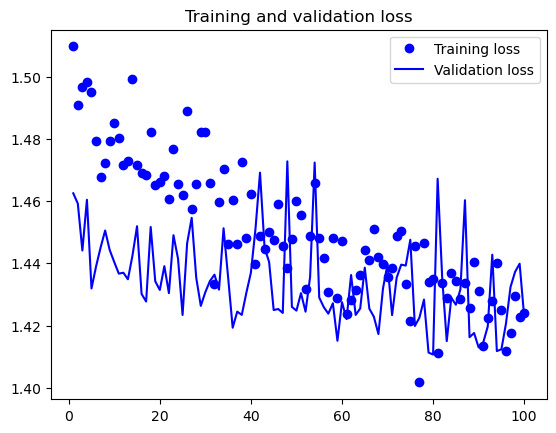

In [181]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [164]:
def create_model(learning_rate=0.01, momentum=0.9):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = SGD(lr=learning_rate, momentum=momentum)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model = KerasClassifier(build_fn=create_model)
param_grid = {
    'learning_rate': [0.01, 0.001],
    'momentum': [0.9, 0.95],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best parameters: ", grid_result.best_params_)
print("Best accuracy: ", grid_result.best_score_)

Epoch 1/10


C:\Users\wojte\AppData\Local\Temp\ipykernel_21704\927849507.py:35: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)
c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.2613 - accuracy: 0.2070
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 2.4986 - accuracy: 0.3055
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.2388 - accuracy: 0.3548
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.1189 - accuracy: 0.3865
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0702 - accuracy: 0.4016
Epoch 6/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0089 - accuracy: 0.4042
Epoch 7/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9259 - accuracy: 0.4271
Epoch 8/10
122/122 [==============================] - 1s 10ms/step - loss: 1.8556 - accuracy: 0.4500
Epoch 9/10
122/122 [==============================] - 1s 10ms/step - loss: 1.8008 - accuracy: 0.4652
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.7030 - accuracy: 0.4810
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.2390 - accuracy: 0.2101
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 2.5606 - accuracy: 0.2834
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.3567 - accuracy: 0.3260
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.2162 - accuracy: 0.3597
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.1080 - accuracy: 0.3790
Epoch 6/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0519 - accuracy: 0.3973
Epoch 7/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9563 - accuracy: 0.4222
Epoch 8/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9307 - accuracy: 0.4325
Epoch 9/10
122/122 [==============================] - 1s 10ms/step - loss: 1.8683 - accuracy: 0.4508
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.8022 - accuracy: 0.4512
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.3127 - accuracy: 0.1753
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 2.5466 - accuracy: 0.2853
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.3456 - accuracy: 0.3254
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.1870 - accuracy: 0.3609
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0670 - accuracy: 0.3895
Epoch 6/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9861 - accuracy: 0.4224
Epoch 7/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9283 - accuracy: 0.4285
Epoch 8/10
122/122 [==============================] - 1s 10ms/step - loss: 1.8725 - accuracy: 0.4344
Epoch 9/10
122/122 [==============================] - 1s 10ms/step - loss: 1.8522 - accuracy: 0.4411
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.8978 - accuracy: 0.4177
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.2710 - accuracy: 0.1889
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 2.5802 - accuracy: 0.2792
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.3531 - accuracy: 0.3180
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.2240 - accuracy: 0.3545
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0967 - accuracy: 0.3771
Epoch 6/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0235 - accuracy: 0.4080
Epoch 7/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9185 - accuracy: 0.4211
Epoch 8/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9182 - accuracy: 0.4288
Epoch 9/10
122/122 [==============================] - 1s 10ms/step - loss: 1.8660 - accuracy: 0.4455
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.6541 - accuracy: 0.4938
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.2577 - accuracy: 0.1902
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 2.5640 - accuracy: 0.2797
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.3709 - accuracy: 0.3064
Epoch 4/10
122/122 [==============================] - 1s 11ms/step - loss: 2.2033 - accuracy: 0.3602
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.1083 - accuracy: 0.3692
Epoch 6/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0300 - accuracy: 0.4039
Epoch 7/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9667 - accuracy: 0.4121
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9063 - accuracy: 0.4324
Epoch 9/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9032 - accuracy: 0.4442
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.6333 - accuracy: 0.4918
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.3909 - accuracy: 0.1880
Epoch 2/10
122/122 [==============================] - 1s 11ms/step - loss: 2.7726 - accuracy: 0.2615
Epoch 3/10
122/122 [==============================] - 1s 11ms/step - loss: 2.4437 - accuracy: 0.3024
Epoch 4/10
122/122 [==============================] - 1s 11ms/step - loss: 2.2454 - accuracy: 0.3533
Epoch 5/10
122/122 [==============================] - 1s 11ms/step - loss: 2.0815 - accuracy: 0.3860
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9958 - accuracy: 0.4006
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9152 - accuracy: 0.4304
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 1.8750 - accuracy: 0.4302
Epoch 9/10
122/122 [==============================] - 1s 11ms/step - loss: 1.8142 - accuracy: 0.4523
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.6807 - accuracy: 0.4882
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.4017 - accuracy: 0.1903
Epoch 2/10
122/122 [==============================] - 1s 11ms/step - loss: 2.7338 - accuracy: 0.2651
Epoch 3/10
122/122 [==============================] - 1s 11ms/step - loss: 2.4162 - accuracy: 0.3176
Epoch 4/10
122/122 [==============================] - 1s 11ms/step - loss: 2.1647 - accuracy: 0.3638
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0506 - accuracy: 0.3988
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9450 - accuracy: 0.4227
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9069 - accuracy: 0.4297
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 1.8132 - accuracy: 0.4610
Epoch 9/10
122/122 [==============================] - 1s 10ms/step - loss: 1.7780 - accuracy: 0.4639
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.7386 - accuracy: 0.4697
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.3684 - accuracy: 0.1985
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 2.7368 - accuracy: 0.2635
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.3499 - accuracy: 0.3201
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.2156 - accuracy: 0.3514
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0558 - accuracy: 0.3982
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9449 - accuracy: 0.4208
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 1.8889 - accuracy: 0.4365
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 1.8497 - accuracy: 0.4396
Epoch 9/10
122/122 [==============================] - 1s 11ms/step - loss: 1.7839 - accuracy: 0.4607
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.7208 - accuracy: 0.4877
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.3252 - accuracy: 0.1807
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 2.6465 - accuracy: 0.2704
Epoch 3/10
122/122 [==============================] - 1s 11ms/step - loss: 2.3911 - accuracy: 0.3190
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.2097 - accuracy: 0.3581
Epoch 5/10
122/122 [==============================] - 1s 11ms/step - loss: 2.0398 - accuracy: 0.4023
Epoch 6/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9806 - accuracy: 0.4170
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9356 - accuracy: 0.4219
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 1.8477 - accuracy: 0.4499
Epoch 9/10
122/122 [==============================] - 1s 11ms/step - loss: 1.7662 - accuracy: 0.4630
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.6938 - accuracy: 0.4866
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.4001 - accuracy: 0.1902
Epoch 2/10
122/122 [==============================] - 1s 11ms/step - loss: 2.7060 - accuracy: 0.2596
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.4169 - accuracy: 0.3041
Epoch 4/10
122/122 [==============================] - 1s 11ms/step - loss: 2.2430 - accuracy: 0.3401
Epoch 5/10
122/122 [==============================] - 1s 11ms/step - loss: 2.1155 - accuracy: 0.3763
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 2.0151 - accuracy: 0.3997
Epoch 7/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9303 - accuracy: 0.4157
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 1.8869 - accuracy: 0.4296
Epoch 9/10
122/122 [==============================] - 1s 10ms/step - loss: 1.8353 - accuracy: 0.4416
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.7211 - accuracy: 0.4619
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.7735 - accuracy: 0.1137
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 3.0750 - accuracy: 0.2127
Epoch 3/10
122/122 [==============================] - 1s 11ms/step - loss: 2.7984 - accuracy: 0.2602
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.5779 - accuracy: 0.3047
Epoch 5/10
122/122 [==============================] - 1s 11ms/step - loss: 2.4733 - accuracy: 0.3212
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 2.3540 - accuracy: 0.3469
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 2.2424 - accuracy: 0.3646
Epoch 8/10
122/122 [==============================] - 1s 10ms/step - loss: 2.2376 - accuracy: 0.3682
Epoch 9/10
122/122 [==============================] - 1s 10ms/step - loss: 2.1510 - accuracy: 0.3788
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.8312 - accuracy: 0.4419
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.7969 - accuracy: 0.1126
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 3.1160 - accuracy: 0.2111
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.7982 - accuracy: 0.2597
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.6252 - accuracy: 0.2944
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.4689 - accuracy: 0.3204
Epoch 6/10
122/122 [==============================] - 1s 10ms/step - loss: 2.3448 - accuracy: 0.3428
Epoch 7/10
122/122 [==============================] - 1s 10ms/step - loss: 2.2644 - accuracy: 0.3618
Epoch 8/10
122/122 [==============================] - 1s 10ms/step - loss: 2.1800 - accuracy: 0.3752
Epoch 9/10
122/122 [==============================] - 1s 11ms/step - loss: 2.1257 - accuracy: 0.3911
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.8304 - accuracy: 0.4666
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.8140 - accuracy: 0.1170
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 3.0937 - accuracy: 0.2188
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.7717 - accuracy: 0.2807
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.6329 - accuracy: 0.2972
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.4394 - accuracy: 0.3267
Epoch 6/10
122/122 [==============================] - 1s 10ms/step - loss: 2.3166 - accuracy: 0.3553
Epoch 7/10
122/122 [==============================] - 1s 10ms/step - loss: 2.2060 - accuracy: 0.3697
Epoch 8/10
122/122 [==============================] - 1s 10ms/step - loss: 2.1400 - accuracy: 0.3936
Epoch 9/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0609 - accuracy: 0.4134
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.9030 - accuracy: 0.4270
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.8732 - accuracy: 0.1015
Epoch 2/10
122/122 [==============================] - 1s 11ms/step - loss: 3.1424 - accuracy: 0.1895
Epoch 3/10
122/122 [==============================] - 1s 11ms/step - loss: 2.8403 - accuracy: 0.2568
Epoch 4/10
122/122 [==============================] - 1s 11ms/step - loss: 2.6375 - accuracy: 0.2859
Epoch 5/10
122/122 [==============================] - 1s 11ms/step - loss: 2.4738 - accuracy: 0.3270
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 2.3676 - accuracy: 0.3321
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 2.2846 - accuracy: 0.3614
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 2.1794 - accuracy: 0.3720
Epoch 9/10
122/122 [==============================] - 1s 11ms/step - loss: 2.1373 - accuracy: 0.3943
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.8548 - accuracy: 0.4475
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.8261 - accuracy: 0.1126
Epoch 2/10
122/122 [==============================] - 1s 11ms/step - loss: 3.2512 - accuracy: 0.1848
Epoch 3/10
122/122 [==============================] - 1s 11ms/step - loss: 2.8829 - accuracy: 0.2352
Epoch 4/10
122/122 [==============================] - 1s 11ms/step - loss: 2.7001 - accuracy: 0.2835
Epoch 5/10
122/122 [==============================] - 1s 11ms/step - loss: 2.5126 - accuracy: 0.3077
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 2.4538 - accuracy: 0.3180
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 2.3331 - accuracy: 0.3519
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 2.2581 - accuracy: 0.3607
Epoch 9/10
122/122 [==============================] - 1s 11ms/step - loss: 2.1565 - accuracy: 0.3763
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.8581 - accuracy: 0.4465
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.6559 - accuracy: 0.1265
Epoch 2/10
122/122 [==============================] - 1s 11ms/step - loss: 2.8115 - accuracy: 0.2584
Epoch 3/10
122/122 [==============================] - 1s 11ms/step - loss: 2.5321 - accuracy: 0.3075
Epoch 4/10
122/122 [==============================] - 1s 11ms/step - loss: 2.3116 - accuracy: 0.3422
Epoch 5/10
122/122 [==============================] - 1s 11ms/step - loss: 2.2141 - accuracy: 0.3710
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 2.0909 - accuracy: 0.4011
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 2.0167 - accuracy: 0.4099
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9285 - accuracy: 0.4258
Epoch 9/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9270 - accuracy: 0.4371
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.7210 - accuracy: 0.4810
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.6627 - accuracy: 0.1350
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 2.8205 - accuracy: 0.2579
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.5217 - accuracy: 0.3088
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.3549 - accuracy: 0.3430
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.2138 - accuracy: 0.3674
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 2.1306 - accuracy: 0.3898
Epoch 7/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0395 - accuracy: 0.4011
Epoch 8/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9622 - accuracy: 0.4333
Epoch 9/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9158 - accuracy: 0.4353
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.8953 - accuracy: 0.4255
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.6949 - accuracy: 0.1290
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 2.8606 - accuracy: 0.2548
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.5183 - accuracy: 0.3077
Epoch 4/10
122/122 [==============================] - 1s 10ms/step - loss: 2.3455 - accuracy: 0.3419
Epoch 5/10
122/122 [==============================] - 1s 10ms/step - loss: 2.2279 - accuracy: 0.3648
Epoch 6/10
122/122 [==============================] - 1s 10ms/step - loss: 2.1265 - accuracy: 0.3789
Epoch 7/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0586 - accuracy: 0.3964
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 2.0033 - accuracy: 0.4190
Epoch 9/10
122/122 [==============================] - 1s 10ms/step - loss: 1.9267 - accuracy: 0.4316
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.8870 - accuracy: 0.4393
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.7516 - accuracy: 0.1278
Epoch 2/10
122/122 [==============================] - 1s 10ms/step - loss: 2.9335 - accuracy: 0.2342
Epoch 3/10
122/122 [==============================] - 1s 10ms/step - loss: 2.5625 - accuracy: 0.2907
Epoch 4/10
122/122 [==============================] - 1s 11ms/step - loss: 2.3777 - accuracy: 0.3470
Epoch 5/10
122/122 [==============================] - 1s 11ms/step - loss: 2.2167 - accuracy: 0.3684
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 2.1322 - accuracy: 0.3933
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 2.0370 - accuracy: 0.4082
Epoch 8/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9782 - accuracy: 0.4157
Epoch 9/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9363 - accuracy: 0.4308
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.7516 - accuracy: 0.4640
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 10ms/step - loss: 3.6816 - accuracy: 0.1283
Epoch 2/10
122/122 [==============================] - 1s 11ms/step - loss: 2.9437 - accuracy: 0.2491
Epoch 3/10
122/122 [==============================] - 1s 11ms/step - loss: 2.6366 - accuracy: 0.2843
Epoch 4/10
122/122 [==============================] - 1s 11ms/step - loss: 2.3870 - accuracy: 0.3301
Epoch 5/10
122/122 [==============================] - 1s 11ms/step - loss: 2.2689 - accuracy: 0.3632
Epoch 6/10
122/122 [==============================] - 1s 11ms/step - loss: 2.1729 - accuracy: 0.3748
Epoch 7/10
122/122 [==============================] - 1s 11ms/step - loss: 2.0890 - accuracy: 0.3990
Epoch 8/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0275 - accuracy: 0.4154
Epoch 9/10
122/122 [==============================] - 1s 11ms/step - loss: 1.9762 - accuracy: 0.4221
Epoch 10/10
31/31 [==============================] - 0s 3ms/step - loss: 1.8264 - accuracy: 0.4372
Epo

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 12ms/step - loss: 3.2387 - accuracy: 0.1959
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.5512 - accuracy: 0.2808
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3429 - accuracy: 0.3255
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2174 - accuracy: 0.3512
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1369 - accuracy: 0.3700
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0544 - accuracy: 0.4011
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0290 - accuracy: 0.4011
Epoch 8/20
122/122 [==============================] - 1s 10ms/step - loss: 1.9537 - accuracy: 0.4163
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9210 - accuracy: 0.4258
Epoch 10/20
122/122 [==============================] - 1s 10ms/step - loss: 1.8806 - accuracy: 0.4428


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.3272 - accuracy: 0.1749
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.6345 - accuracy: 0.2638
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.4414 - accuracy: 0.3011
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2759 - accuracy: 0.3268
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1512 - accuracy: 0.3677
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0849 - accuracy: 0.3813
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0051 - accuracy: 0.4024
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9678 - accuracy: 0.4045
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9300 - accuracy: 0.4181
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8846 - accuracy: 0.4366


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.2578 - accuracy: 0.1979
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.5745 - accuracy: 0.2820
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3056 - accuracy: 0.3370
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1882 - accuracy: 0.3581
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0947 - accuracy: 0.3853
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9954 - accuracy: 0.4123
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9636 - accuracy: 0.4134
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9276 - accuracy: 0.4224
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8547 - accuracy: 0.4337
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8159 - accuracy: 0.4440


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.2665 - accuracy: 0.1905
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.5449 - accuracy: 0.2769
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3413 - accuracy: 0.3254
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1754 - accuracy: 0.3584
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1217 - accuracy: 0.3743
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0489 - accuracy: 0.3859
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9435 - accuracy: 0.4262
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9110 - accuracy: 0.4298
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8815 - accuracy: 0.4337
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8235 - accuracy: 0.4427


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.2259 - accuracy: 0.1964
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.5831 - accuracy: 0.2895
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3103 - accuracy: 0.3308
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1812 - accuracy: 0.3604
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0929 - accuracy: 0.3825
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0548 - accuracy: 0.3923
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9600 - accuracy: 0.4095
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9196 - accuracy: 0.4352
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8558 - accuracy: 0.4473
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8152 - accuracy: 0.4586


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.3953 - accuracy: 0.1880
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.6974 - accuracy: 0.2702
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.4005 - accuracy: 0.3150
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2535 - accuracy: 0.3458
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0828 - accuracy: 0.3826
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0150 - accuracy: 0.4088
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9413 - accuracy: 0.4235
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8743 - accuracy: 0.4438
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8301 - accuracy: 0.4505
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.7645 - accuracy: 0.4703


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.4094 - accuracy: 0.1808
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.7566 - accuracy: 0.2648
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.4359 - accuracy: 0.3140
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2555 - accuracy: 0.3433
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0811 - accuracy: 0.3955
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9845 - accuracy: 0.4124
Epoch 7/20
122/122 [==============================] - 2s 12ms/step - loss: 1.9325 - accuracy: 0.4240
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8677 - accuracy: 0.4384
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8311 - accuracy: 0.4531
Epoch 10/20
122/122 [==============================] - 1s 12ms/step - loss: 1.7684 - accuracy: 0.4698


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.3964 - accuracy: 0.1951
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.6275 - accuracy: 0.2877
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3878 - accuracy: 0.3177
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1686 - accuracy: 0.3620
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0631 - accuracy: 0.3928
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9465 - accuracy: 0.4219
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8627 - accuracy: 0.4316
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8128 - accuracy: 0.4589
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.7712 - accuracy: 0.4604
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.7369 - accuracy: 0.4689


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.3989 - accuracy: 0.1866
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.7919 - accuracy: 0.2702
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3893 - accuracy: 0.3260
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2224 - accuracy: 0.3499
Epoch 5/20
122/122 [==============================] - 1s 12ms/step - loss: 2.0798 - accuracy: 0.3851
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9772 - accuracy: 0.4085
Epoch 7/20
122/122 [==============================] - 1s 12ms/step - loss: 1.9301 - accuracy: 0.4198
Epoch 8/20
122/122 [==============================] - 1s 12ms/step - loss: 1.8366 - accuracy: 0.4378
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8337 - accuracy: 0.4452
Epoch 10/20
122/122 [==============================] - 1s 12ms/step - loss: 1.7855 - accuracy: 0.4586


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.4561 - accuracy: 0.1694
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.7317 - accuracy: 0.2686
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.4484 - accuracy: 0.3005
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2842 - accuracy: 0.3388
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1646 - accuracy: 0.3602
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0649 - accuracy: 0.3900
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9993 - accuracy: 0.4046
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9596 - accuracy: 0.4093
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8924 - accuracy: 0.4306
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8351 - accuracy: 0.4393


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.8011 - accuracy: 0.1227
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 3.1183 - accuracy: 0.2101
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.8233 - accuracy: 0.2592
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.5785 - accuracy: 0.3029
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.4463 - accuracy: 0.3235
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3487 - accuracy: 0.3389
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2415 - accuracy: 0.3613
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1905 - accuracy: 0.3775
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1291 - accuracy: 0.3839
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0573 - accuracy: 0.3993


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.8108 - accuracy: 0.1126
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 3.1807 - accuracy: 0.1995
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.8185 - accuracy: 0.2566
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.6546 - accuracy: 0.2849
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.4587 - accuracy: 0.3119
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3794 - accuracy: 0.3330
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2862 - accuracy: 0.3564
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1514 - accuracy: 0.3893
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1157 - accuracy: 0.3957
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0740 - accuracy: 0.4096


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.8694 - accuracy: 0.1057
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 3.1631 - accuracy: 0.1925
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.8151 - accuracy: 0.2661
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.5940 - accuracy: 0.3003
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.4660 - accuracy: 0.3183
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3562 - accuracy: 0.3409
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2487 - accuracy: 0.3563
Epoch 8/20
122/122 [==============================] - 1s 10ms/step - loss: 2.1868 - accuracy: 0.3815
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1081 - accuracy: 0.3918
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0604 - accuracy: 0.4028


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.8166 - accuracy: 0.1154
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 3.1531 - accuracy: 0.2064
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.7888 - accuracy: 0.2578
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.6392 - accuracy: 0.2902
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.4630 - accuracy: 0.3280
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3723 - accuracy: 0.3404
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2949 - accuracy: 0.3504
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2059 - accuracy: 0.3825
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1450 - accuracy: 0.3907
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1032 - accuracy: 0.3982


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.8014 - accuracy: 0.1123
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 3.1476 - accuracy: 0.2054
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.8363 - accuracy: 0.2558
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.6885 - accuracy: 0.2774
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.5252 - accuracy: 0.3051
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3954 - accuracy: 0.3239
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2729 - accuracy: 0.3532
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2539 - accuracy: 0.3540
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1902 - accuracy: 0.3712
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1603 - accuracy: 0.3841


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.6516 - accuracy: 0.1273
Epoch 2/20
122/122 [==============================] - 1s 10ms/step - loss: 2.8438 - accuracy: 0.2507
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.5462 - accuracy: 0.3109
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3600 - accuracy: 0.3389
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2244 - accuracy: 0.3662
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1348 - accuracy: 0.3806
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0381 - accuracy: 0.4011
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9608 - accuracy: 0.4220
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9049 - accuracy: 0.4333
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8618 - accuracy: 0.4454


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 13ms/step - loss: 3.6454 - accuracy: 0.1466
Epoch 2/20
122/122 [==============================] - 1s 12ms/step - loss: 2.8329 - accuracy: 0.2584
Epoch 3/20
122/122 [==============================] - 1s 12ms/step - loss: 2.5391 - accuracy: 0.3070
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3632 - accuracy: 0.3291
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2183 - accuracy: 0.3644
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1406 - accuracy: 0.3901
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0421 - accuracy: 0.4094
Epoch 8/20
122/122 [==============================] - 1s 12ms/step - loss: 1.9738 - accuracy: 0.4240
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9283 - accuracy: 0.4328
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8820 - accuracy: 0.4446


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 12ms/step - loss: 3.7573 - accuracy: 0.1183
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.9402 - accuracy: 0.2234
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.6311 - accuracy: 0.2874
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.4005 - accuracy: 0.3254
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2385 - accuracy: 0.3607
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1479 - accuracy: 0.3812
Epoch 7/20
122/122 [==============================] - 1s 12ms/step - loss: 2.1006 - accuracy: 0.3779
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0031 - accuracy: 0.4067
Epoch 9/20
122/122 [==============================] - 1s 12ms/step - loss: 1.9783 - accuracy: 0.4159
Epoch 10/20
122/122 [==============================] - 1s 12ms/step - loss: 1.9356 - accuracy: 0.4239


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 12ms/step - loss: 3.6867 - accuracy: 0.1326
Epoch 2/20
122/122 [==============================] - 1s 12ms/step - loss: 2.8865 - accuracy: 0.2494
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.5261 - accuracy: 0.3141
Epoch 4/20
122/122 [==============================] - 1s 12ms/step - loss: 2.3698 - accuracy: 0.3373
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2326 - accuracy: 0.3730
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1492 - accuracy: 0.3735
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0675 - accuracy: 0.3961
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9368 - accuracy: 0.4308
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9618 - accuracy: 0.4272
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.8716 - accuracy: 0.4491


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


122/122 [==============================] - 2s 11ms/step - loss: 3.6811 - accuracy: 0.1270
Epoch 2/20
122/122 [==============================] - 1s 11ms/step - loss: 2.9987 - accuracy: 0.2288
Epoch 3/20
122/122 [==============================] - 1s 11ms/step - loss: 2.6509 - accuracy: 0.2884
Epoch 4/20
122/122 [==============================] - 1s 11ms/step - loss: 2.3887 - accuracy: 0.3247
Epoch 5/20
122/122 [==============================] - 1s 11ms/step - loss: 2.2761 - accuracy: 0.3535
Epoch 6/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1520 - accuracy: 0.3820
Epoch 7/20
122/122 [==============================] - 1s 11ms/step - loss: 2.1065 - accuracy: 0.3892
Epoch 8/20
122/122 [==============================] - 1s 11ms/step - loss: 2.0262 - accuracy: 0.4013
Epoch 9/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9809 - accuracy: 0.4111
Epoch 10/20
122/122 [==============================] - 1s 11ms/step - loss: 1.9144 - accuracy: 0.4239


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.4546 - accuracy: 0.1679
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 2.5803 - accuracy: 0.2872
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.3059 - accuracy: 0.3412
Epoch 4/10
61/61 [==============================] - 1s 18ms/step - loss: 2.1783 - accuracy: 0.3641
Epoch 5/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0705 - accuracy: 0.3852
Epoch 6/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0238 - accuracy: 0.4019
Epoch 7/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9607 - accuracy: 0.4150
Epoch 8/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9124 - accuracy: 0.4248
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8626 - accuracy: 0.4394
Epoch 10/10
16/16 [==============================] - 0s 5ms/step - loss: 1.7810 - accuracy: 0.4625
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.3682 - accuracy: 0.1893
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 2.5287 - accuracy: 0.3062
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.2887 - accuracy: 0.3464
Epoch 4/10
61/61 [==============================] - 1s 18ms/step - loss: 2.1057 - accuracy: 0.3867
Epoch 5/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0256 - accuracy: 0.4083
Epoch 6/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9345 - accuracy: 0.4204
Epoch 7/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8944 - accuracy: 0.4286
Epoch 8/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8511 - accuracy: 0.4379
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 1.7936 - accuracy: 0.4520
Epoch 10/10
16/16 [==============================] - 0s 5ms/step - loss: 1.7837 - accuracy: 0.4430
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.4456 - accuracy: 0.1640
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 2.6421 - accuracy: 0.2720
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.3580 - accuracy: 0.3190
Epoch 4/10
61/61 [==============================] - 1s 18ms/step - loss: 2.2105 - accuracy: 0.3535
Epoch 5/10
61/61 [==============================] - 1s 18ms/step - loss: 2.1082 - accuracy: 0.3792
Epoch 6/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9941 - accuracy: 0.3985
Epoch 7/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9603 - accuracy: 0.4195
Epoch 8/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8917 - accuracy: 0.4388
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8405 - accuracy: 0.4388
Epoch 10/10
16/16 [==============================] - 0s 5ms/step - loss: 1.7902 - accuracy: 0.4424
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.3956 - accuracy: 0.1681
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 2.6016 - accuracy: 0.2802
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.3330 - accuracy: 0.3401
Epoch 4/10
61/61 [==============================] - 1s 18ms/step - loss: 2.1536 - accuracy: 0.3689
Epoch 5/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0408 - accuracy: 0.3964
Epoch 6/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9992 - accuracy: 0.4141
Epoch 7/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9223 - accuracy: 0.4280
Epoch 8/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8786 - accuracy: 0.4429
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8314 - accuracy: 0.4532
Epoch 10/10
16/16 [==============================] - 0s 5ms/step - loss: 1.6846 - accuracy: 0.5082
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.4933 - accuracy: 0.1545
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 2.6215 - accuracy: 0.2792
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.3453 - accuracy: 0.3270
Epoch 4/10
61/61 [==============================] - 1s 19ms/step - loss: 2.2068 - accuracy: 0.3501
Epoch 5/10
61/61 [==============================] - 1s 19ms/step - loss: 2.0841 - accuracy: 0.3864
Epoch 6/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0172 - accuracy: 0.4008
Epoch 7/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9688 - accuracy: 0.4134
Epoch 8/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8866 - accuracy: 0.4265
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8732 - accuracy: 0.4339
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.6645 - accuracy: 0.4897
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.4473 - accuracy: 0.1661
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 2.6838 - accuracy: 0.2605
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.3866 - accuracy: 0.3101
Epoch 4/10
61/61 [==============================] - 1s 18ms/step - loss: 2.2422 - accuracy: 0.3446
Epoch 5/10
61/61 [==============================] - 1s 18ms/step - loss: 2.1402 - accuracy: 0.3685
Epoch 6/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0488 - accuracy: 0.3988
Epoch 7/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9958 - accuracy: 0.4078
Epoch 8/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9347 - accuracy: 0.4214
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9054 - accuracy: 0.4171
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.9390 - accuracy: 0.3854
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.3767 - accuracy: 0.1720
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 2.5673 - accuracy: 0.2882
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.3271 - accuracy: 0.3320
Epoch 4/10
61/61 [==============================] - 1s 18ms/step - loss: 2.1681 - accuracy: 0.3682
Epoch 5/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0623 - accuracy: 0.3896
Epoch 6/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0171 - accuracy: 0.4047
Epoch 7/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9372 - accuracy: 0.4173
Epoch 8/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8820 - accuracy: 0.4338
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8479 - accuracy: 0.4510
Epoch 10/10
16/16 [==============================] - 0s 5ms/step - loss: 1.9591 - accuracy: 0.4142
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.3661 - accuracy: 0.1874
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 2.4953 - accuracy: 0.3026
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.2603 - accuracy: 0.3450
Epoch 4/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0960 - accuracy: 0.3820
Epoch 5/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0156 - accuracy: 0.4077
Epoch 6/10
61/61 [==============================] - 1s 18ms/step - loss: 1.9225 - accuracy: 0.4183
Epoch 7/10
61/61 [==============================] - 1s 19ms/step - loss: 1.8631 - accuracy: 0.4455
Epoch 8/10
61/61 [==============================] - 1s 18ms/step - loss: 1.8508 - accuracy: 0.4488
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 1.7900 - accuracy: 0.4542
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.7534 - accuracy: 0.4681
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.3580 - accuracy: 0.1751
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 2.5684 - accuracy: 0.2871
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.2945 - accuracy: 0.3334
Epoch 4/10
61/61 [==============================] - 1s 19ms/step - loss: 2.2195 - accuracy: 0.3517
Epoch 5/10
61/61 [==============================] - 1s 19ms/step - loss: 2.0858 - accuracy: 0.3805
Epoch 6/10
61/61 [==============================] - 1s 19ms/step - loss: 2.0269 - accuracy: 0.3905
Epoch 7/10
61/61 [==============================] - 1s 19ms/step - loss: 1.9563 - accuracy: 0.4159
Epoch 8/10
61/61 [==============================] - 1s 19ms/step - loss: 1.8745 - accuracy: 0.4334
Epoch 9/10
61/61 [==============================] - 1s 19ms/step - loss: 1.8579 - accuracy: 0.4434
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.9434 - accuracy: 0.3940
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.3720 - accuracy: 0.1746
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 2.6038 - accuracy: 0.2864
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.3138 - accuracy: 0.3375
Epoch 4/10
61/61 [==============================] - 1s 18ms/step - loss: 2.2028 - accuracy: 0.3589
Epoch 5/10
61/61 [==============================] - 1s 18ms/step - loss: 2.1274 - accuracy: 0.3766
Epoch 6/10
61/61 [==============================] - 1s 19ms/step - loss: 2.0234 - accuracy: 0.3956
Epoch 7/10
61/61 [==============================] - 1s 21ms/step - loss: 1.9645 - accuracy: 0.4152
Epoch 8/10
61/61 [==============================] - 1s 21ms/step - loss: 1.9158 - accuracy: 0.4195
Epoch 9/10
61/61 [==============================] - 1s 19ms/step - loss: 1.8837 - accuracy: 0.4352
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.8626 - accuracy: 0.4249
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.9925 - accuracy: 0.0869
Epoch 2/10
61/61 [==============================] - 1s 19ms/step - loss: 3.3582 - accuracy: 0.1697
Epoch 3/10
61/61 [==============================] - 1s 20ms/step - loss: 3.0465 - accuracy: 0.2191
Epoch 4/10
61/61 [==============================] - 1s 20ms/step - loss: 2.8273 - accuracy: 0.2661
Epoch 5/10
61/61 [==============================] - 1s 19ms/step - loss: 2.6322 - accuracy: 0.2962
Epoch 6/10
61/61 [==============================] - 1s 21ms/step - loss: 2.5162 - accuracy: 0.3222
Epoch 7/10
61/61 [==============================] - 1s 21ms/step - loss: 2.4312 - accuracy: 0.3397
Epoch 8/10
61/61 [==============================] - 1s 20ms/step - loss: 2.3511 - accuracy: 0.3628
Epoch 9/10
61/61 [==============================] - 1s 20ms/step - loss: 2.2835 - accuracy: 0.3710
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.9639 - accuracy: 0.4327
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 4.0614 - accuracy: 0.0874
Epoch 2/10
61/61 [==============================] - 1s 19ms/step - loss: 3.5150 - accuracy: 0.1481
Epoch 3/10
61/61 [==============================] - 1s 20ms/step - loss: 3.1883 - accuracy: 0.1977
Epoch 4/10
61/61 [==============================] - 1s 20ms/step - loss: 2.8492 - accuracy: 0.2430
Epoch 5/10
61/61 [==============================] - 1s 19ms/step - loss: 2.7286 - accuracy: 0.2841
Epoch 6/10
61/61 [==============================] - 1s 22ms/step - loss: 2.5942 - accuracy: 0.3073
Epoch 7/10
61/61 [==============================] - 1s 20ms/step - loss: 2.4756 - accuracy: 0.3250
Epoch 8/10
61/61 [==============================] - 1s 20ms/step - loss: 2.4081 - accuracy: 0.3497
Epoch 9/10
61/61 [==============================] - 1s 19ms/step - loss: 2.3342 - accuracy: 0.3551
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 2.0328 - accuracy: 0.4018
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 20ms/step - loss: 3.9895 - accuracy: 0.1044
Epoch 2/10
61/61 [==============================] - 1s 19ms/step - loss: 3.3218 - accuracy: 0.1848
Epoch 3/10
61/61 [==============================] - 1s 19ms/step - loss: 3.0159 - accuracy: 0.2280
Epoch 4/10
61/61 [==============================] - 1s 19ms/step - loss: 2.7699 - accuracy: 0.2604
Epoch 5/10
61/61 [==============================] - 1s 19ms/step - loss: 2.6049 - accuracy: 0.3129
Epoch 6/10
61/61 [==============================] - 1s 20ms/step - loss: 2.5463 - accuracy: 0.3103
Epoch 7/10
61/61 [==============================] - 1s 20ms/step - loss: 2.4460 - accuracy: 0.3224
Epoch 8/10
61/61 [==============================] - 1s 19ms/step - loss: 2.3722 - accuracy: 0.3527
Epoch 9/10
61/61 [==============================] - 1s 19ms/step - loss: 2.2999 - accuracy: 0.3550
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.9883 - accuracy: 0.4198
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.9747 - accuracy: 0.0943
Epoch 2/10
61/61 [==============================] - 1s 19ms/step - loss: 3.4219 - accuracy: 0.1620
Epoch 3/10
61/61 [==============================] - 1s 19ms/step - loss: 3.1158 - accuracy: 0.2177
Epoch 4/10
61/61 [==============================] - 1s 19ms/step - loss: 2.8718 - accuracy: 0.2499
Epoch 5/10
61/61 [==============================] - 1s 19ms/step - loss: 2.7505 - accuracy: 0.2861
Epoch 6/10
61/61 [==============================] - 1s 19ms/step - loss: 2.5422 - accuracy: 0.3141
Epoch 7/10
61/61 [==============================] - 1s 20ms/step - loss: 2.4532 - accuracy: 0.3440
Epoch 8/10
61/61 [==============================] - 1s 19ms/step - loss: 2.4234 - accuracy: 0.3470
Epoch 9/10
61/61 [==============================] - 1s 19ms/step - loss: 2.3471 - accuracy: 0.3591
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.9656 - accuracy: 0.4372
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.9817 - accuracy: 0.0895
Epoch 2/10
61/61 [==============================] - 1s 19ms/step - loss: 3.3976 - accuracy: 0.1658
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 3.0709 - accuracy: 0.2195
Epoch 4/10
61/61 [==============================] - 1s 19ms/step - loss: 2.8817 - accuracy: 0.2537
Epoch 5/10
61/61 [==============================] - 1s 20ms/step - loss: 2.6968 - accuracy: 0.2794
Epoch 6/10
61/61 [==============================] - 1s 19ms/step - loss: 2.5713 - accuracy: 0.3023
Epoch 7/10
61/61 [==============================] - 1s 18ms/step - loss: 2.4817 - accuracy: 0.3234
Epoch 8/10
61/61 [==============================] - 1s 20ms/step - loss: 2.4055 - accuracy: 0.3473
Epoch 9/10
61/61 [==============================] - 1s 19ms/step - loss: 2.3350 - accuracy: 0.3540
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 2.0770 - accuracy: 0.3889
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 19ms/step - loss: 3.8787 - accuracy: 0.1175
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 3.1145 - accuracy: 0.2227
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.7534 - accuracy: 0.2852
Epoch 4/10
61/61 [==============================] - 1s 19ms/step - loss: 2.5975 - accuracy: 0.3093
Epoch 5/10
61/61 [==============================] - 1s 19ms/step - loss: 2.4277 - accuracy: 0.3335
Epoch 6/10
61/61 [==============================] - 1s 19ms/step - loss: 2.3013 - accuracy: 0.3510
Epoch 7/10
61/61 [==============================] - 1s 20ms/step - loss: 2.2213 - accuracy: 0.3734
Epoch 8/10
61/61 [==============================] - 1s 19ms/step - loss: 2.1401 - accuracy: 0.3893
Epoch 9/10
61/61 [==============================] - 1s 19ms/step - loss: 2.0768 - accuracy: 0.4029
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.8585 - accuracy: 0.4430
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.8929 - accuracy: 0.1121
Epoch 2/10
61/61 [==============================] - 1s 18ms/step - loss: 3.1089 - accuracy: 0.2175
Epoch 3/10
61/61 [==============================] - 1s 18ms/step - loss: 2.6905 - accuracy: 0.2893
Epoch 4/10
61/61 [==============================] - 1s 18ms/step - loss: 2.4988 - accuracy: 0.3276
Epoch 5/10
61/61 [==============================] - 1s 19ms/step - loss: 2.3594 - accuracy: 0.3541
Epoch 6/10
61/61 [==============================] - 1s 19ms/step - loss: 2.2718 - accuracy: 0.3749
Epoch 7/10
61/61 [==============================] - 1s 18ms/step - loss: 2.1887 - accuracy: 0.3919
Epoch 8/10
61/61 [==============================] - 1s 19ms/step - loss: 2.1495 - accuracy: 0.3924
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 2.0682 - accuracy: 0.4052
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.8302 - accuracy: 0.4532
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 4.0590 - accuracy: 0.0859
Epoch 2/10
61/61 [==============================] - 1s 19ms/step - loss: 3.2712 - accuracy: 0.1884
Epoch 3/10
61/61 [==============================] - 1s 19ms/step - loss: 2.8575 - accuracy: 0.2571
Epoch 4/10
61/61 [==============================] - 1s 19ms/step - loss: 2.5825 - accuracy: 0.3036
Epoch 5/10
61/61 [==============================] - 1s 19ms/step - loss: 2.4932 - accuracy: 0.3252
Epoch 6/10
61/61 [==============================] - 1s 19ms/step - loss: 2.3626 - accuracy: 0.3419
Epoch 7/10
61/61 [==============================] - 1s 19ms/step - loss: 2.2386 - accuracy: 0.3743
Epoch 8/10
61/61 [==============================] - 1s 19ms/step - loss: 2.1597 - accuracy: 0.3915
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 2.1139 - accuracy: 0.4046
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.9414 - accuracy: 0.4239
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 20ms/step - loss: 3.9518 - accuracy: 0.1057
Epoch 2/10
61/61 [==============================] - 1s 20ms/step - loss: 3.1795 - accuracy: 0.1956
Epoch 3/10
61/61 [==============================] - 1s 19ms/step - loss: 2.8535 - accuracy: 0.2463
Epoch 4/10
61/61 [==============================] - 1s 21ms/step - loss: 2.5791 - accuracy: 0.3062
Epoch 5/10
61/61 [==============================] - 1s 19ms/step - loss: 2.4279 - accuracy: 0.3231
Epoch 6/10
61/61 [==============================] - 1s 20ms/step - loss: 2.3019 - accuracy: 0.3542
Epoch 7/10
61/61 [==============================] - 1s 21ms/step - loss: 2.2016 - accuracy: 0.3761
Epoch 8/10
61/61 [==============================] - 1s 21ms/step - loss: 2.1059 - accuracy: 0.3931
Epoch 9/10
61/61 [==============================] - 1s 21ms/step - loss: 2.0614 - accuracy: 0.4149
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.9879 - accuracy: 0.4146
Epoch 1/10


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.9303 - accuracy: 0.1003
Epoch 2/10
61/61 [==============================] - 1s 20ms/step - loss: 3.2300 - accuracy: 0.1838
Epoch 3/10
61/61 [==============================] - 1s 20ms/step - loss: 2.8626 - accuracy: 0.2470
Epoch 4/10
61/61 [==============================] - 1s 20ms/step - loss: 2.6353 - accuracy: 0.2884
Epoch 5/10
61/61 [==============================] - 1s 18ms/step - loss: 2.4626 - accuracy: 0.3167
Epoch 6/10
61/61 [==============================] - 1s 18ms/step - loss: 2.3315 - accuracy: 0.3380
Epoch 7/10
61/61 [==============================] - 1s 18ms/step - loss: 2.2618 - accuracy: 0.3666
Epoch 8/10
61/61 [==============================] - 1s 18ms/step - loss: 2.2060 - accuracy: 0.3748
Epoch 9/10
61/61 [==============================] - 1s 18ms/step - loss: 2.1305 - accuracy: 0.3925
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 1.9439 - accuracy: 0.4002
Epoch 1/20


c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 20ms/step - loss: 3.4084 - accuracy: 0.1684
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5554 - accuracy: 0.2908
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2754 - accuracy: 0.3536
Epoch 4/20
61/61 [==============================] - 1s 20ms/step - loss: 2.1407 - accuracy: 0.3844
Epoch 5/20
61/61 [==============================] - 1s 20ms/step - loss: 2.0318 - accuracy: 0.4068
Epoch 6/20
61/61 [==============================] - 1s 20ms/step - loss: 1.9657 - accuracy: 0.4163
Epoch 7/20
61/61 [==============================] - 1s 21ms/step - loss: 1.8860 - accuracy: 0.4292
Epoch 8/20
61/61 [==============================] - 1s 20ms/step - loss: 1.8492 - accuracy: 0.4384
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 1.7971 - accuracy: 0.4562
Epoch 10/20
61/61 [==============================] - 1s 20ms/step - loss: 1.7629 - accuracy: 0.4685
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.2952 - accuracy: 0.1849
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5225 - accuracy: 0.3029
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2574 - accuracy: 0.3528
Epoch 4/20
61/61 [==============================] - 1s 21ms/step - loss: 2.1090 - accuracy: 0.3934
Epoch 5/20
61/61 [==============================] - 1s 21ms/step - loss: 2.0176 - accuracy: 0.4045
Epoch 6/20
61/61 [==============================] - 1s 20ms/step - loss: 1.9162 - accuracy: 0.4266
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8609 - accuracy: 0.4343
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8061 - accuracy: 0.4631
Epoch 9/20
61/61 [==============================] - 1s 20ms/step - loss: 1.7725 - accuracy: 0.4677
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 1.7573 - accuracy: 0.4682
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 20ms/step - loss: 3.4134 - accuracy: 0.1746
Epoch 2/20
61/61 [==============================] - 1s 20ms/step - loss: 2.5196 - accuracy: 0.2982
Epoch 3/20
61/61 [==============================] - 1s 20ms/step - loss: 2.2869 - accuracy: 0.3416
Epoch 4/20
61/61 [==============================] - 1s 19ms/step - loss: 2.1291 - accuracy: 0.3815
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0447 - accuracy: 0.3902
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 1.9560 - accuracy: 0.4134
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8827 - accuracy: 0.4303
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8627 - accuracy: 0.4411
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8129 - accuracy: 0.4558
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 1.7449 - accuracy: 0.4648
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 19ms/step - loss: 3.5228 - accuracy: 0.1499
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 2.6656 - accuracy: 0.2620
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3901 - accuracy: 0.3219
Epoch 4/20
61/61 [==============================] - 1s 19ms/step - loss: 2.1809 - accuracy: 0.3650
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0895 - accuracy: 0.3810
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0352 - accuracy: 0.4044
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 1.9442 - accuracy: 0.4057
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8943 - accuracy: 0.4360
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8330 - accuracy: 0.4524
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 1.7983 - accuracy: 0.4594
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.3333 - accuracy: 0.1900
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5059 - accuracy: 0.3118
Epoch 3/20
61/61 [==============================] - 1s 18ms/step - loss: 2.2355 - accuracy: 0.3566
Epoch 4/20
61/61 [==============================] - 1s 18ms/step - loss: 2.0988 - accuracy: 0.3967
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 1.9959 - accuracy: 0.4157
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 1.9133 - accuracy: 0.4339
Epoch 7/20
61/61 [==============================] - 1s 18ms/step - loss: 1.8588 - accuracy: 0.4344
Epoch 8/20
61/61 [==============================] - 1s 18ms/step - loss: 1.8389 - accuracy: 0.4483
Epoch 9/20
61/61 [==============================] - 1s 18ms/step - loss: 1.7801 - accuracy: 0.4550
Epoch 10/20
61/61 [==============================] - 1s 18ms/step - loss: 1.7478 - accuracy: 0.4776
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.4163 - accuracy: 0.1710
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5972 - accuracy: 0.2808
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3457 - accuracy: 0.3176
Epoch 4/20
61/61 [==============================] - 1s 18ms/step - loss: 2.2467 - accuracy: 0.3433
Epoch 5/20
61/61 [==============================] - 1s 18ms/step - loss: 2.1656 - accuracy: 0.3559
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0669 - accuracy: 0.3777
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0072 - accuracy: 0.4060
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 1.9495 - accuracy: 0.4194
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8705 - accuracy: 0.4351
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8308 - accuracy: 0.4502
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 18ms/step - loss: 3.3079 - accuracy: 0.1916
Epoch 2/20
61/61 [==============================] - 1s 18ms/step - loss: 2.5358 - accuracy: 0.2805
Epoch 3/20
61/61 [==============================] - 1s 18ms/step - loss: 2.2800 - accuracy: 0.3322
Epoch 4/20
61/61 [==============================] - 1s 18ms/step - loss: 2.1662 - accuracy: 0.3646
Epoch 5/20
61/61 [==============================] - 1s 18ms/step - loss: 2.0682 - accuracy: 0.3821
Epoch 6/20
61/61 [==============================] - 1s 18ms/step - loss: 1.9873 - accuracy: 0.4124
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 1.9238 - accuracy: 0.4266
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8791 - accuracy: 0.4346
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8261 - accuracy: 0.4574
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 1.7717 - accuracy: 0.4628
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.3623 - accuracy: 0.1825
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5673 - accuracy: 0.2967
Epoch 3/20
61/61 [==============================] - 1s 20ms/step - loss: 2.3180 - accuracy: 0.3252
Epoch 4/20
61/61 [==============================] - 1s 19ms/step - loss: 2.1758 - accuracy: 0.3694
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0676 - accuracy: 0.3825
Epoch 6/20
61/61 [==============================] - 1s 20ms/step - loss: 2.0009 - accuracy: 0.4059
Epoch 7/20
61/61 [==============================] - 1s 20ms/step - loss: 1.9463 - accuracy: 0.4162
Epoch 8/20
61/61 [==============================] - 1s 20ms/step - loss: 1.8803 - accuracy: 0.4401
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8233 - accuracy: 0.4452
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 1.7580 - accuracy: 0.4740
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.3606 - accuracy: 0.1833
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5265 - accuracy: 0.2910
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2698 - accuracy: 0.3401
Epoch 4/20
61/61 [==============================] - 1s 20ms/step - loss: 2.1271 - accuracy: 0.3663
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0633 - accuracy: 0.3874
Epoch 6/20
61/61 [==============================] - 1s 20ms/step - loss: 1.9908 - accuracy: 0.3964
Epoch 7/20
61/61 [==============================] - 1s 20ms/step - loss: 1.9116 - accuracy: 0.4380
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8786 - accuracy: 0.4370
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8426 - accuracy: 0.4509
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 1.7686 - accuracy: 0.4663
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.3665 - accuracy: 0.1805
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5897 - accuracy: 0.2751
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3249 - accuracy: 0.3303
Epoch 4/20
61/61 [==============================] - 1s 20ms/step - loss: 2.1699 - accuracy: 0.3692
Epoch 5/20
61/61 [==============================] - 1s 20ms/step - loss: 2.0949 - accuracy: 0.3756
Epoch 6/20
61/61 [==============================] - 1s 20ms/step - loss: 2.0288 - accuracy: 0.4000
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 1.9753 - accuracy: 0.4039
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 1.9372 - accuracy: 0.4201
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8746 - accuracy: 0.4406
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 1.8391 - accuracy: 0.4409
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.9741 - accuracy: 0.0941
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 3.4359 - accuracy: 0.1651
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 3.0952 - accuracy: 0.2181
Epoch 4/20
61/61 [==============================] - 1s 19ms/step - loss: 2.8423 - accuracy: 0.2574
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.6801 - accuracy: 0.2908
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5513 - accuracy: 0.3222
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 2.4514 - accuracy: 0.3446
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3723 - accuracy: 0.3559
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3041 - accuracy: 0.3613
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2043 - accuracy: 0.3793
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 19ms/step - loss: 3.9386 - accuracy: 0.0967
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 3.2927 - accuracy: 0.1833
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.9526 - accuracy: 0.2499
Epoch 4/20
61/61 [==============================] - 1s 19ms/step - loss: 2.7441 - accuracy: 0.2718
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.6145 - accuracy: 0.3060
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5297 - accuracy: 0.3145
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3765 - accuracy: 0.3471
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3308 - accuracy: 0.3615
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2671 - accuracy: 0.3698
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2241 - accuracy: 0.3692
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 20ms/step - loss: 4.0345 - accuracy: 0.0869
Epoch 2/20
61/61 [==============================] - 1s 20ms/step - loss: 3.4286 - accuracy: 0.1566
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 3.0300 - accuracy: 0.2226
Epoch 4/20
61/61 [==============================] - 1s 19ms/step - loss: 2.8220 - accuracy: 0.2612
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.6440 - accuracy: 0.2985
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5379 - accuracy: 0.3126
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 2.4537 - accuracy: 0.3293
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3451 - accuracy: 0.3576
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2947 - accuracy: 0.3630
Epoch 10/20
61/61 [==============================] - 1s 18ms/step - loss: 2.2133 - accuracy: 0.3776
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 19ms/step - loss: 3.9718 - accuracy: 0.0923
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 3.3508 - accuracy: 0.1740
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.9814 - accuracy: 0.2347
Epoch 4/20
61/61 [==============================] - 1s 19ms/step - loss: 2.7584 - accuracy: 0.2679
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.6475 - accuracy: 0.2992
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5318 - accuracy: 0.3252
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 2.4438 - accuracy: 0.3398
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3767 - accuracy: 0.3411
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3059 - accuracy: 0.3625
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2771 - accuracy: 0.3630
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 1s 19ms/step - loss: 4.0791 - accuracy: 0.0853
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 3.3843 - accuracy: 0.1766
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 3.0564 - accuracy: 0.2231
Epoch 4/20
61/61 [==============================] - 1s 19ms/step - loss: 2.8242 - accuracy: 0.2599
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.7147 - accuracy: 0.2704
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 2.6013 - accuracy: 0.3039
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 2.4832 - accuracy: 0.3267
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 2.4171 - accuracy: 0.3262
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3472 - accuracy: 0.3576
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2887 - accuracy: 0.3594
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 20ms/step - loss: 3.9111 - accuracy: 0.1031
Epoch 2/20
61/61 [==============================] - 1s 20ms/step - loss: 3.1838 - accuracy: 0.1970
Epoch 3/20
61/61 [==============================] - 1s 20ms/step - loss: 2.7598 - accuracy: 0.2746
Epoch 4/20
61/61 [==============================] - 1s 20ms/step - loss: 2.5587 - accuracy: 0.3204
Epoch 5/20
61/61 [==============================] - 1s 20ms/step - loss: 2.4621 - accuracy: 0.3183
Epoch 6/20
61/61 [==============================] - 1s 20ms/step - loss: 2.3330 - accuracy: 0.3492
Epoch 7/20
61/61 [==============================] - 1s 20ms/step - loss: 2.2245 - accuracy: 0.3620
Epoch 8/20
61/61 [==============================] - 1s 20ms/step - loss: 2.1507 - accuracy: 0.3798
Epoch 9/20
61/61 [==============================] - 1s 20ms/step - loss: 2.0959 - accuracy: 0.3914
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0485 - accuracy: 0.4034
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.9029 - accuracy: 0.1090
Epoch 2/20
61/61 [==============================] - 1s 20ms/step - loss: 3.1534 - accuracy: 0.1967
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.7997 - accuracy: 0.2664
Epoch 4/20
61/61 [==============================] - 1s 20ms/step - loss: 2.6093 - accuracy: 0.2998
Epoch 5/20
61/61 [==============================] - 1s 20ms/step - loss: 2.3914 - accuracy: 0.3412
Epoch 6/20
61/61 [==============================] - 1s 20ms/step - loss: 2.3222 - accuracy: 0.3471
Epoch 7/20
61/61 [==============================] - 1s 20ms/step - loss: 2.2238 - accuracy: 0.3654
Epoch 8/20
61/61 [==============================] - 1s 20ms/step - loss: 2.1656 - accuracy: 0.3839
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 2.1111 - accuracy: 0.3950
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 1.9844 - accuracy: 0.4256
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 20ms/step - loss: 3.9583 - accuracy: 0.0949
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 3.1974 - accuracy: 0.1943
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.7694 - accuracy: 0.2823
Epoch 4/20
61/61 [==============================] - 1s 20ms/step - loss: 2.5632 - accuracy: 0.2882
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.4551 - accuracy: 0.3219
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3262 - accuracy: 0.3488
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2028 - accuracy: 0.3656
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 2.1351 - accuracy: 0.3781
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0860 - accuracy: 0.4023
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0160 - accuracy: 0.4113
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.8724 - accuracy: 0.1069
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 3.1224 - accuracy: 0.2003
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.7469 - accuracy: 0.2702
Epoch 4/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5537 - accuracy: 0.3152
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3953 - accuracy: 0.3375
Epoch 6/20
61/61 [==============================] - 1s 20ms/step - loss: 2.2692 - accuracy: 0.3676
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 2.1742 - accuracy: 0.3797
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 2.1128 - accuracy: 0.3936
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0621 - accuracy: 0.4072
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0228 - accuracy: 0.4069
Epoch 11/20
61/61 [=

c:\Users\wojte\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - 2s 19ms/step - loss: 3.9469 - accuracy: 0.1036
Epoch 2/20
61/61 [==============================] - 1s 19ms/step - loss: 3.2247 - accuracy: 0.1992
Epoch 3/20
61/61 [==============================] - 1s 19ms/step - loss: 2.8136 - accuracy: 0.2650
Epoch 4/20
61/61 [==============================] - 1s 19ms/step - loss: 2.5489 - accuracy: 0.3141
Epoch 5/20
61/61 [==============================] - 1s 19ms/step - loss: 2.4305 - accuracy: 0.3357
Epoch 6/20
61/61 [==============================] - 1s 19ms/step - loss: 2.3011 - accuracy: 0.3594
Epoch 7/20
61/61 [==============================] - 1s 19ms/step - loss: 2.2476 - accuracy: 0.3740
Epoch 8/20
61/61 [==============================] - 1s 19ms/step - loss: 2.1402 - accuracy: 0.4008
Epoch 9/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0873 - accuracy: 0.4008
Epoch 10/20
61/61 [==============================] - 1s 19ms/step - loss: 2.0683 - accuracy: 0.4000
Epoch 11/20
61/61 [=

images/4285fab0-751a-4b74-8e9b-43af05deee22.jpg


<bound method Image.close of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533 at 0x2741770CEB0>>

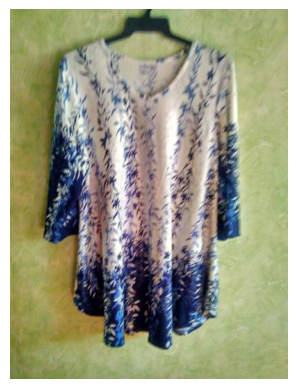

In [288]:
name = df.iloc[sample]['image']
name = name + '.jpg'

path = 'images/'
path = path + name
print(path)

image = Image.open(path)

plt.imshow(image), plt.axis('off'), plt.grid(False)
image.close

images/4285fab0-751a-4b74-8e9b-43af05deee22.jpg


<bound method Image.close of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533 at 0x2740E213550>>

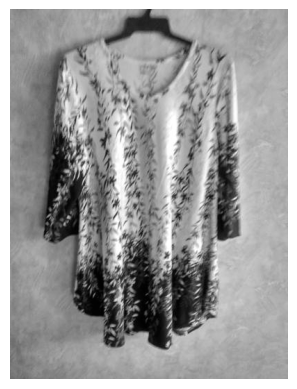

In [289]:
name = df.iloc[sample]['image']
name = name + '.jpg'

path = 'images/'
path = path + name
print(path)

image = Image.open(path)
imgage_gray = image.convert('LA')

image_mat = np.array(list(imgage_gray.getdata(band=0)), float)
image_mat.shape = (imgage_gray.size[1], imgage_gray.size[0])
image_mat = np.matrix(image_mat)

plt.imshow(image_mat, cmap='gray'), plt.axis('off'), plt.grid(False)
image.close

(<matplotlib.image.AxesImage at 0x2740eae4d60>, (-0.5, 27.5, 27.5, -0.5), None)

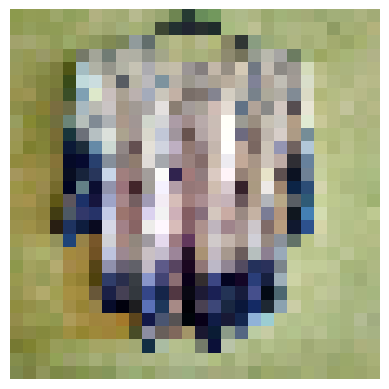

In [290]:
from tensorflow.keras.preprocessing import image

img = image.load_img(path, target_size=(size, size))
plt.imshow(img), plt.axis('off'), plt.grid(False)

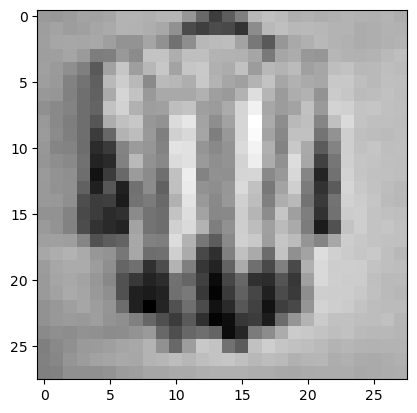

In [291]:
image = images[sample]

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

<bound method Image.close of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533 at 0x2740D05EBB0>>

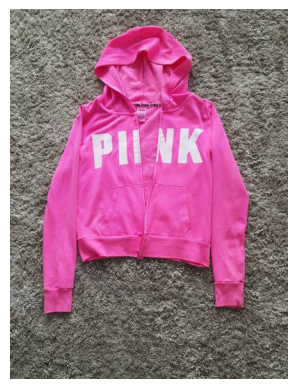

In [305]:
image_path = './test/hoodie.jpg'

image = Image.open(image_path)

plt.imshow(image), plt.axis('off'), plt.grid(False)
image.close

In [306]:
image_path = './test/hoodie.jpg'
image = Image.open(image_path).convert('L')
image = image.resize((size, size))

image_array = np.array(image) / 255.0
image_input = image_array.reshape(1, size, size, 1)

model = tf.keras.models.load_model('./model.h5')

predictions = model.predict(image_input)
predicted_label = np.argmax(predictions[0])
predicted_class = label_encoder.classes_[predicted_label]

print(predicted_class)

1/1 [==============================] - 0s 29ms/step
13


In [307]:
image_path = './test/hoodie.jpg'
image = Image.open(image_path).convert('L')
image = image.resize((size, size))

image_array = np.array(image) / 255.0
image_input = image_array.reshape(1, size, size, 1)

model2 = tf.keras.models.load_model('./model2.h5')

predictions = model2.predict(image_input)
predicted_label = np.argmax(predictions[0])
predicted_class = label_encoder.classes_[predicted_label]

print(predicted_class)

1/1 [==============================] - 0s 60ms/step
17


In [314]:
print('Model 1:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print('Model 2:')
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Model 1:
Test loss: 1.5476288795471191
Test accuracy: 0.5619223713874817
Model 2:
Test loss: 1.5818051099777222
Test accuracy: 0.6007393598556519


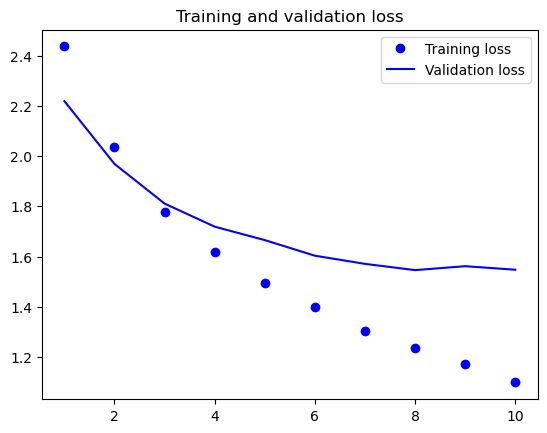

In [315]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

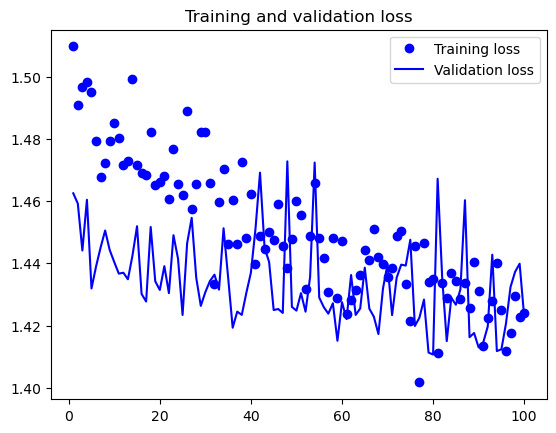

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

17/17 [==============================] - 0s 2ms/step


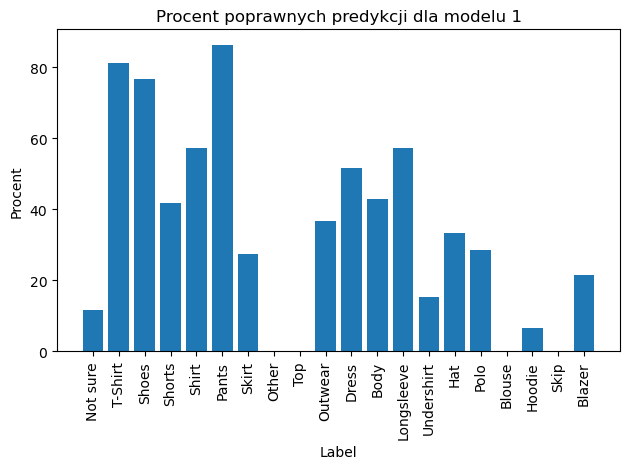

In [312]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

label_mapping = {
    0: 'Not sure',
    1: 'T-Shirt', 
    2: 'Shoes',
    3: 'Shorts',
    4: 'Shirt',
    5: 'Pants',
    6: 'Skirt',
    7: 'Other',
    8: 'Top',
    9: 'Outwear',
    10: 'Dress',
    11: 'Body',
    12: 'Longsleeve',
    13: 'Undershirt',
    14: 'Hat',
    15: 'Polo',
    16: 'Blouse',
    17: 'Hoodie',
    18: 'Skip',
    19: 'Blazer'
    }

correct_predictions = np.equal(y_pred_labels, y_test)
correct_per_label = np.bincount(y_test[correct_predictions])

total_per_label = np.bincount(y_test)

percent_correct_per_label = (correct_per_label / total_per_label) * 100

labels = [label_mapping[i] for i in range(num_classes)]
x = np.arange(len(labels))

plt.bar(x, percent_correct_per_label)
plt.xlabel('Label')
plt.ylabel('Procent')
plt.xticks(x, labels, rotation='vertical')
plt.title('Procent poprawnych predykcji dla modelu 1')
plt.tight_layout()
plt.show()

17/17 [==============================] - 0s 4ms/step


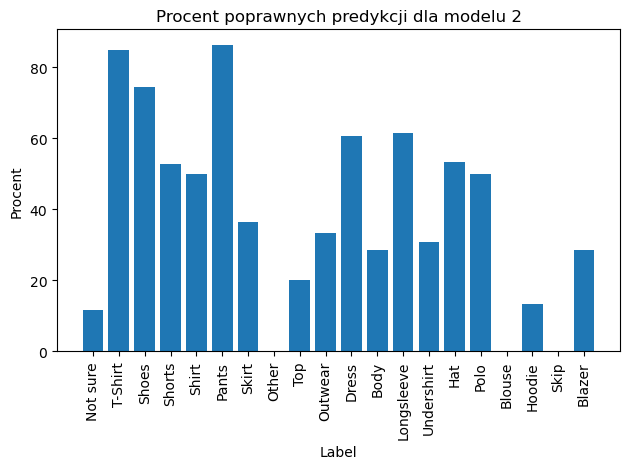

In [313]:
y_pred = model2.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

label_mapping = {
    0: 'Not sure',
    1: 'T-Shirt', 
    2: 'Shoes',
    3: 'Shorts',
    4: 'Shirt',
    5: 'Pants',
    6: 'Skirt',
    7: 'Other',
    8: 'Top',
    9: 'Outwear',
    10: 'Dress',
    11: 'Body',
    12: 'Longsleeve',
    13: 'Undershirt',
    14: 'Hat',
    15: 'Polo',
    16: 'Blouse',
    17: 'Hoodie',
    18: 'Skip',
    19: 'Blazer'
    }

correct_predictions = np.equal(y_pred_labels, y_test)
correct_per_label = np.bincount(y_test[correct_predictions])

total_per_label = np.bincount(y_test)

percent_correct_per_label = (correct_per_label / total_per_label) * 100

labels = [label_mapping[i] for i in range(num_classes)]
x = np.arange(len(labels))

plt.bar(x, percent_correct_per_label)
plt.xlabel('Label')
plt.ylabel('Procent')
plt.xticks(x, labels, rotation='vertical')
plt.title('Procent poprawnych predykcji dla modelu 2')
plt.tight_layout()
plt.show()